In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, BertTokenizer, BertConfig, BertForMaskedLM
import copy
import os

## Prepare Dataloader

In [3]:
data_path = './data/'
# df1 = pd.read_csv(os.path.join(data_path, 'cleaned/kaggle.csv'))
# df2 = pd.read_csv(os.path.join(data_path, 'cleaned/enron.csv'))
# df3 = pd.read_csv(os.path.join(data_path, 'cleaned/ling.csv'))
# df4 = pd.read_csv(os.path.join(data_path, 'cleaned/assassin.csv'))
# df = pd.concat([df1, df2, df3, df4])
df = pd.read_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'))

In [4]:
df.shape

(36868, 4)

In [ ]:
df.head(5)

,text,original_text,spam,source
0,""" From: fork-admin@xent.com [mailto:fork-admi...",""" From: fork-admin@xent.com [mailto:fork-admi...",0,assassin.csv
1,"""Hi, On Sun, 01 Sep 2002 00:05:03 MDT Reg Clem...","""Hi, On Sun, 01 Sep 2002 00:05:03 MDT Reg Clem...",0,assassin.csv
2,"""On Fri Sep 13 2002 at 02:03, Robert Elz wrote...","""On Fri Sep 13 2002 at 02:03, Robert Elz wrote...",0,assassin.csv
3,"""On Thu, 2002-08-29 at 01:06, Matthias Saou wr...","""On Thu, 2002-08-29 at 01:06, Matthias Saou wr...",0,assassin.csv
4,"""Hi, I'm building an rpm for the resin webserv...","""Hi, I'm building an rpm for the resin webserv...",0,assassin.csv


In [4]:
df['source'].value_counts()

source
enron.csv       28271
assassin.csv     5757
ling.csv         2840
Name: count, dtype: int64

In [5]:
df['source'].value_counts(normalize=True)

source
enron.csv       0.766817
assassin.csv    0.156152
ling.csv        0.077032
Name: proportion, dtype: float64

In [5]:
df['spam'].value_counts(normalize=True)

spam
0    0.573777
1    0.426223
Name: proportion, dtype: float64

In [6]:
df = df.rename(columns={"spam":"label"})

In [7]:
df['n_words'] = [len(x.split()) for x in
                        df['original_text'].str.lower()]

In [ ]:
df.describe()

,label,n_unique_words,n_words
count,36489.000000,36489.000000,36489.000000
mean,0.427554,148.308696,341.906657
std,0.494730,185.815565,826.948084
min,0.000000,1.000000,1.000000
25%,0.000000,57.000000,79.000000
50%,0.000000,99.000000,165.000000
75%,1.000000,175.000000,361.000000
max,1.000000,5183.000000,45450.000000


In [ ]:
df[df.label==1].describe()

,label,n_unique_words,n_words
count,15601.0,15601.000000,15601.000000
mean,1.0,141.445036,294.965515
std,0.0,152.306934,484.350986
min,1.0,1.000000,1.000000
25%,1.0,56.000000,75.000000
50%,1.0,91.000000,144.000000
75%,1.0,166.000000,304.000000
max,1.0,3433.000000,11441.000000


In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['original_text'], df['label'],
                                                                    random_state=5260,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=5260,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
max_seq_len = 400

In [11]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


In [14]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Fine-tune Pre-Trained Bert Model

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

In [16]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [17]:
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = RandomSampler(test_data)

# dataLoader for train set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [19]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
device = torch.device("cuda")
# push the model to GPU
model = model.to(device)

In [21]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)
print(class_wts)

[0.87144594 1.17304545]


In [23]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy  = nn.NLLLoss(weight=weights)
# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
  model.train()
  total_loss, total_correct_predictions, total_samples, total_accuracy = 0, 0, 0, 0
  # empty list to save model predictions
  # total_preds =[]
  for step,batch in enumerate(train_dataloader):

    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
      print(f"\nTraining Accuracy: {total_correct_predictions/total_samples*100:.2f}%\n")

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients
    model.zero_grad()

    preds = model(sent_id, mask)
    preds_prob = torch.exp(preds)
    _, class_preds  = torch.max(preds_prob, dim=1)

    correct_predictions = (class_preds == labels).sum().item()
    total_correct_predictions += correct_predictions

    total_samples += labels.shape[0]
    train_accuracy = total_correct_predictions / total_samples

    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()

    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  train_accuracy = total_correct_predictions / total_samples

  return avg_loss, train_accuracy

In [ ]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss, total_correct_predictions, total_accuracy, total_samples = 0, 0, 0, 0
  # empty list to save the model predictions
  total_preds_prob = []
  total_preds_class = []
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
      print(f"\nValidation Accuracy: {total_correct_predictions/total_samples*100:.2f}%\n")
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      preds_prob = torch.exp(preds)
      spam_prob = preds_prob[:, 1]
      _, class_preds  = torch.max(preds_prob, dim=1)
      correct_predictions = (class_preds == labels).sum().item()
      total_correct_predictions += correct_predictions
      total_samples += labels.shape[0]

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()

      spam_prob = spam_prob.detach().cpu().numpy()
      total_preds_prob.append(spam_prob)
      total_preds_class.append(class_preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  return avg_loss, total_preds_class, total_preds_prob

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy = train()

    #evaluate model
    valid_loss, preds_class, preds_prob = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_bert_400.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 5
  Batch   100  of    799.

Training Accuracy: 71.69%

  Batch   200  of    799.

Training Accuracy: 76.22%

  Batch   300  of    799.

Training Accuracy: 79.14%

  Batch   400  of    799.

Training Accuracy: 80.80%

  Batch   500  of    799.

Training Accuracy: 82.11%

  Batch   600  of    799.

Training Accuracy: 83.04%

  Batch   700  of    799.

Training Accuracy: 83.63%


Evaluating...
  Batch    50  of    172.

Validation Accuracy: 81.31%

  Batch   100  of    172.

Validation Accuracy: 80.72%

  Batch   150  of    172.

Validation Accuracy: 80.21%


Training Loss: 0.350
Validation Loss: 0.395

 Epoch 2 / 5
  Batch   100  of    799.

Training Accuracy: 87.25%

  Batch   200  of    799.

Training Accuracy: 87.61%

  Batch   300  of    799.

Training Accuracy: 88.29%

  Batch   400  of    799.

Training Accuracy: 88.37%

  Batch   500  of    799.

Training Accuracy: 88.62%

  Batch   600  of    799.

Training Accuracy: 89.14%

  Batch   700  of    799.

Training Accura

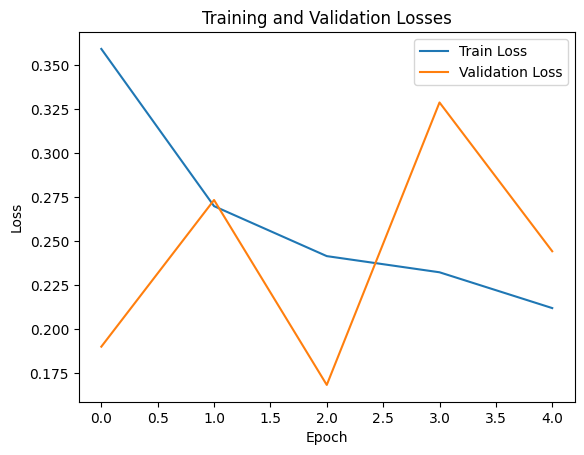

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

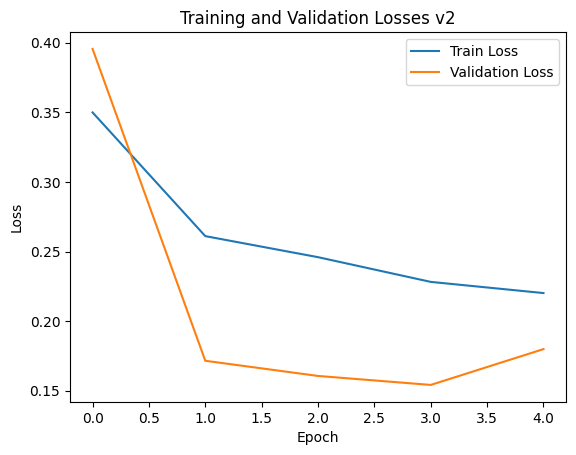

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses v2')
plt.legend()
plt.show()

## Testing

In [24]:
#load weights of best model
path = 'saved_weights_bert_400.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#load weights of best model
total_preds_prob = []
total_preds_class = []
total_loss, total_correct_predictions, total_accuracy, total_samples = 0, 0, 0, 0
actual_label = []
# get predictions for test data
for step,batch in enumerate(test_dataloader):
  # push the batch to gpu
  batch = [t.to(device) for t in batch]
  sent_id, mask, labels = batch
  # model predictions
  preds = model(sent_id, mask)
  preds_prob = torch.exp(preds)
  spam_prob = preds_prob[:, 1]
  _, class_preds  = torch.max(preds_prob, dim=1)
  correct_predictions = (class_preds == labels).sum().item()
  total_correct_predictions += correct_predictions

  # compute the validation loss between actual and predicted values
  loss = cross_entropy(preds,labels)
  total_loss = total_loss + loss.item()

  spam_prob = spam_prob.detach().cpu().numpy()
  total_preds_prob.append(spam_prob)
  class_preds = class_preds.detach().cpu().numpy()
  total_preds_class.append(class_preds)
  labels = labels.detach().cpu().numpy()
  actual_label.append(labels)

  total_samples += labels.shape[0]

# compute the validation loss of the epoch
avg_loss = total_loss / total_samples
test_accuracy = total_correct_predictions / total_samples


In [ ]:
test_accuracy

0.9373057941875342

In [ ]:
# model's performance
total_actual_class = np.concatenate(actual_label)
total_preds_class = np.concatenate(total_preds_class)
print(classification_report(total_actual_class, total_preds_class))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3133
           1       0.90      0.96      0.93      2338

    accuracy                           0.94      5471
   macro avg       0.93      0.94      0.94      5471
weighted avg       0.94      0.94      0.94      5471



## Attack on Testing Dataset

In [ ]:
filter_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost',
                'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another',
                'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as',
                'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides',
                'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn',
                "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere',
                'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'first', 'for',
                'former', 'formerly', 'from', 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'he', 'hence',
                'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his',
                'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's",
                'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn',
                "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly', 'must', 'mustn', "mustn't", 'my', 'myself',
                'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none',
                'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only',
                'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per',
                'please', 's', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow',
                'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
                'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein',
                'thereupon', 'these', 'they', 'this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too',
                'toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used', 've', 'was', 'wasn', "wasn't",
                'we', 'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where',
                'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while',
                'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won',
                "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've",
                'your', 'yours', 'yourself', 'yourselves']
filter_words = set(filter_words)

In [ ]:
original_texts = df.iloc[test_labels.index]['original_text']

In [ ]:
test_labels.value_counts()

label
0    3174
1    2357
Name: count, dtype: int64

In [ ]:
def get_data_cls(texts, labels, text_tokens):
    features = []
    for i, text in enumerate(texts):
        idx = texts.index[i]
        label = labels[idx]
        if label == 0:
            continue
        seq = text
        input_ids = text_tokens['input_ids'][i]
        attention_mask = text_tokens['attention_mask'][i]
        features.append([seq, label, input_ids, attention_mask])
    return features

In [ ]:
class Feature(object):
    def __init__(self, seq_a, label, input_ids, attention_mask):
        self.label = label
        self.seq = seq_a
        self.final_adverse = seq_a
        self.query = 0
        self.change = 0
        self.success = 0
        self.sim = 0.0
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.changes = []
        self.orig_prob = 0.0
        self.adv_prob = 0.0

In [ ]:
def _tokenize(seq, tokenizer):
    seq = seq.replace('\n', '').lower()
    words = seq.split(' ')

    sub_words = []
    keys = []
    index = 0
    for word in words:
        sub = tokenizer.tokenize(word)
        sub_words += sub
        keys.append([index, index + len(sub)])
        index += len(sub)

    return words, sub_words, keys

In [ ]:
config_atk = BertConfig.from_pretrained('bert-base-uncased')
mlm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', config=config_atk)
mlm_model = mlm_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# mlm_model = bert
tgt_model = model

In [ ]:
def _get_masked(words):
    len_text = len(words)
    masked_words = []
    for i in range(len_text - 1):
        masked_words.append(words[0:i] + ['[UNK]'] + words[i + 1:])
    # list of words
    return masked_words

In [ ]:
def get_important_scores(words, tgt_model, orig_prob, orig_label, orig_probs, tokenizer, batch_size, max_length):
    masked_words = _get_masked(words)
    texts = [' '.join(words) for words in masked_words]  # list of text of masked words
    all_input_ids = []
    all_masks = []
    for text in texts:
        inputs = tokenizer.encode_plus(text, None, add_special_tokens=True, max_length=max_length, )
        input_ids = inputs["input_ids"]
        attention_mask = [1] * len(input_ids)
        padding_length = max_length - len(input_ids)
        input_ids = input_ids + (padding_length * [0])
        attention_mask = attention_mask + (padding_length * [0])
        all_input_ids.append(input_ids)
        all_masks.append(attention_mask)
    seqs = torch.tensor(all_input_ids, dtype=torch.long)
    masks = torch.tensor(all_masks, dtype=torch.long)
    seqs = seqs.to('cuda')
    masks = masks.to('cuda')

    eval_data = TensorDataset(seqs, masks)
    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)
    leave_1_probs = []
    for batch in eval_dataloader:
        seq_id, mask = batch
        # bs = seq_id.size(0)
        leave_1_prob_batch = tgt_model(seq_id, mask)  # B num-label
        leave_1_probs.append(leave_1_prob_batch)
    leave_1_probs = torch.cat(leave_1_probs, dim=0)  # words, num-label
    leave_1_probs = torch.exp(leave_1_probs)
    leave_1_probs_argmax = torch.argmax(leave_1_probs, dim=-1)
    import_scores = (orig_prob
                     - leave_1_probs[:, orig_label]
                     +
                     (leave_1_probs_argmax != orig_label).float()
                     * (leave_1_probs.max(dim=-1)[0] - torch.index_select(orig_probs, 0, leave_1_probs_argmax))
                     ).data.cpu().numpy()

    return import_scores

In [ ]:
def get_bpe_substitues(substitutes, tokenizer, mlm_model):
    # substitutes L, k

    substitutes = substitutes[0:12, 0:4] # maximum BPE candidates

    # find all possible candidates

    all_substitutes = []
    for i in range(substitutes.size(0)):
        if len(all_substitutes) == 0:
            lev_i = substitutes[i]
            all_substitutes = [[int(c)] for c in lev_i]
        else:
            lev_i = []
            for all_sub in all_substitutes:
                for j in substitutes[i]:
                    lev_i.append(all_sub + [int(j)])
            all_substitutes = lev_i

    # all substitutes  list of list of token-id (all candidates)
    c_loss = nn.CrossEntropyLoss(reduction='none')
    word_list = []
    # all_substitutes = all_substitutes[:24]
    all_substitutes = torch.tensor(all_substitutes) # [ N, L ]
    all_substitutes = all_substitutes[:24].to('cuda')
    # print(substitutes.size(), all_substitutes.size())
    N, L = all_substitutes.size()
    word_predictions = mlm_model(all_substitutes)[0] # N L vocab-size
    ppl = c_loss(word_predictions.view(N*L, -1), all_substitutes.view(-1)) # [ N*L ]
    ppl = torch.exp(torch.mean(ppl.view(N, L), dim=-1)) # N
    _, word_list = torch.sort(ppl)
    word_list = [all_substitutes[i] for i in word_list]
    final_words = []
    for word in word_list:
        tokens = [tokenizer._convert_id_to_token(int(i)) for i in word]
        text = tokenizer.convert_tokens_to_string(tokens)
        final_words.append(text)
    return final_words

In [ ]:
def get_substitues(substitutes, tokenizer, mlm_model, use_bpe, substitutes_score=None, threshold=3.0):
    # substitues L,k
    # from this matrix to recover a word
    words = []
    sub_len, k = substitutes.size()  # sub-len, k

    if sub_len == 0:
        return words

    elif sub_len == 1:
        for (i,j) in zip(substitutes[0], substitutes_score[0]):
            if threshold != 0 and j < threshold:
                break
            words.append(tokenizer._convert_id_to_token(int(i)))
    else:
        if use_bpe == 1:
            words = get_bpe_substitues(substitutes, tokenizer, mlm_model)
        else:
            return words
    #
    # print(words)
    return words


In [ ]:
def attack(feature, tgt_model, mlm_model, tokenizer, k, batch_size, max_length=512, use_bpe=1, threshold_pred_score=0.3):
    # MLM-process
    words, sub_words, keys = _tokenize(feature.seq, tokenizer)

    # original label
    inputs = tokenizer.encode_plus(feature.seq, None, add_special_tokens=True, max_length=max_length, )
    input_ids = torch.tensor(inputs["input_ids"])
    attention_mask = torch.tensor([1] * len(input_ids))
    seq_len = input_ids.size(0)
    orig_probs = tgt_model(input_ids.unsqueeze(0).to('cuda'),
                           attention_mask.unsqueeze(0).to('cuda')).squeeze()
    orig_probs = torch.exp(orig_probs)
    orig_label = torch.argmax(orig_probs)
    current_prob = orig_probs.max()
    feature.orig_prob = orig_probs[-1].item()

    if orig_label != feature.label:
        feature.success = 3
        return feature

    sub_words = ['[CLS]'] + sub_words[:max_length - 2] + ['[SEP]']
    input_ids_ = torch.tensor([tokenizer.convert_tokens_to_ids(sub_words)])
    word_predictions = mlm_model(input_ids_.to('cuda'))[0].squeeze()  # seq-len(sub) vocab
    word_pred_scores_all, word_predictions = torch.topk(word_predictions, k, -1)  # seq-len k

    word_predictions = word_predictions[1:len(sub_words) + 1, :]
    word_pred_scores_all = word_pred_scores_all[1:len(sub_words) + 1, :]

    important_scores = get_important_scores(words, tgt_model, current_prob, orig_label, orig_probs,
                                            tokenizer, batch_size, max_length)
    feature.query += int(len(words))
    list_of_index = sorted(enumerate(important_scores), key=lambda x: x[1], reverse=True)
    # print(list_of_index)
    final_words = copy.deepcopy(words)

    for top_index in list_of_index:
        if feature.change > int(0.4 * (len(words))):
            feature.success = 1  # exceed
            return feature

        tgt_word = words[top_index[0]]
        if tgt_word in filter_words:
            continue
        if keys[top_index[0]][0] > max_length - 2:
            continue
        substitutes = word_predictions[keys[top_index[0]][0]:keys[top_index[0]][1]]  # L, k
        word_pred_scores = word_pred_scores_all[keys[top_index[0]][0]:keys[top_index[0]][1]]
        substitutes = get_substitues(substitutes, tokenizer, mlm_model, use_bpe, word_pred_scores, threshold_pred_score)

        most_gap = 0.0
        candidate = None

        for substitute_ in substitutes:
            substitute = substitute_

            if substitute == tgt_word:
                continue  # filter out original word
            if '##' in substitute:
                continue  # filter out sub-word
            if substitute in filter_words:
                continue
            temp_replace = final_words
            temp_replace[top_index[0]] = substitute
            temp_text = tokenizer.convert_tokens_to_string(temp_replace)
            inputs = tokenizer.encode_plus(temp_text, None, add_special_tokens=True, max_length=max_length, )
            input_ids = torch.tensor(inputs["input_ids"]).unsqueeze(0).to('cuda')
            attention_mask = torch.tensor(inputs["attention_mask"]).unsqueeze(0).to('cuda')
            seq_len = input_ids.size(1)
            temp_prob = tgt_model(input_ids, attention_mask).squeeze()
            feature.query += 1
            temp_prob = torch.exp(temp_prob)
            temp_label = torch.argmax(temp_prob)
            if temp_label != orig_label:
                feature.change += 1
                final_words[top_index[0]] = substitute
                feature.changes.append([keys[top_index[0]][0], substitute, tgt_word])
                feature.final_adverse = temp_text
                feature.success = 4
                feature.adv_prob = temp_prob[-1].item()
                return feature
            else:
                label_prob = temp_prob[orig_label]
                gap = current_prob - label_prob
                if gap > most_gap:
                    most_gap = gap
                    candidate = substitute

        if most_gap > 0:
            feature.change += 1
            feature.changes.append([keys[top_index[0]][0], candidate, tgt_word])
            current_prob = current_prob - most_gap
            final_words[top_index[0]] = candidate
            feature.adv_prob = current_prob.item()

    feature.final_adverse = (tokenizer.convert_tokens_to_string(final_words))
    feature.success = 2
    return feature

In [ ]:
def evaluate_attack(features):
    sim_thres = 0
    acc = 0
    origin_success = 0
    total = 0
    total_q = 0
    total_change = 0
    total_word = 0
    for index, row in features.iterrows():
        if row['success'] > 2:
            acc += 1
            total_q += row['query']
            total_change += row['change']
            total_word += len(row['original_text'].split(' '))
            if row['success'] == 3:
                origin_success += 1
        total += 1
    suc = float(acc / total)
    query = float(total_q / acc)
    change_rate = float(total_change / total_word)
    origin_acc = 1 - origin_success / total
    after_atk = 1 - suc
    print('acc/aft-atk-acc {:.6f}/ {:.6f}, query-num {:.4f}, change-rate {:.4f}'.format(origin_acc, after_atk, query, change_rate))

In [ ]:
features_output = []
features = get_data_cls(original_texts, test_labels, tokens_test)

In [ ]:
len(features)

2357

In [ ]:
# 500
#
with torch.no_grad():
    for index, feature in enumerate(features[0:500]):
        seq_a, label, input_ids, attention_mask  = feature
        feat = Feature(seq_a, label, input_ids, attention_mask)
        print('\r number {:d} '.format(index), end='')
        # print(feat.seq[:100], feat.label)
        feat = attack(feat, tgt_model, mlm_model, tokenizer, 10, batch_size=32, max_length=200, use_bpe=1,threshold_pred_score=0)

        # print(feat.changes, feat.change, feat.query, feat.success)
        if feat.success > 2:
            print('success', end='')
        else:
            print('failed', end='')
        features_output.append(feat)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 number 499 failed

In [ ]:
outputs = []
for feature in features_output:
      outputs.append({'label': feature.label,
                      'orig_prob': feature.orig_prob,
                      'adv_prob': feature.adv_prob,
                      'success': feature.success,
                      'change': feature.change,
                      'num_word': len(feature.seq.split(' ')),
                      'query': feature.query,
                      'changes': feature.changes,
                      'original_text': feature.seq,
                      'adv_text': feature.final_adverse,
                      })
outputs_df = pd.DataFrame(outputs)
outputs_df.head(3)

,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text
0,1,0.897920,0.625242,2,2,242,1426,"[[5, ′, '], [41, phlesrol, cholesterol]]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...
1,1,0.995630,0.558946,2,10,283,1354,"[[12, no. running, non-stop], [185, that, s, t...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....
2,1,0.996536,0.804369,2,4,137,825,"[[130, /, info], [15, ,, )], [66, attitude, im...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...


In [ ]:
outputs_df.to_csv('./bert result/bert_adv_result_0_500.csv', index=False)

In [ ]:
outputs_df = pd.read_csv('./bert result/bert_adv_result_0_500.csv')
outputs_df.head(3)

,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text
0,1,0.897920,0.625242,2,2,242,1426,"[[5, '′', ""'""], [41, 'phlesrol', 'cholesterol']]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...
1,1,0.995630,0.558946,2,10,283,1354,"[[12, 'no. running', 'non-stop'], [185, 'that,...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....
2,1,0.996536,0.804369,2,4,137,825,"[[130, '/', 'info'], [15, ',', ')'], [66, 'att...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...


In [ ]:
outputs_df.shape

(500, 10)

In [ ]:
evaluate_attack(outputs_df)

acc/aft-atk-acc 0.958000/ 0.584000, query-num 444.7788, change-rate 0.0134


In [ ]:
ex_feat = outputs_df.iloc[3]

In [ ]:
print(ex_feat.label)
print(ex_feat.success)
print(ex_feat.query)
print(ex_feat.changes)
print(ex_feat.orig_prob)
print(ex_feat.adv_prob)
print(ex_feat.original_text)
print(ex_feat.adv_text)

1
2
577
[[32, 'test', 'miracle'], [82, 'large', 'immense'], [37, 'formed', 'built'], [7, '...', '!'], [85, '. of', '!much'], [35, 'had', 'has'], [25, 'type', 'kind'], [51, '″', '"'], [72, ';', '.'], [8, 'enhancement→', 'augment'], [50, '10', '2']]
0.9967899322509766
0.6362974047660828
no catch . . . genuine study ! augment your phallus . no dodge - - - genuine study ! the such kind of research
that composed another miracle narcotics , has now built up a revolutionary
grass tablet that can gain your member rate by 2 " to 5 "
in precisely a several abbreviated hebdomads ! only swallow 3 my pills each day . . .
it will do your penis addition a immense 22 % !
much more information

no point /? ' fake inquiry... enhancement→ your phallo | no question k c ing mere test ) the such type of researcherthet written another test medication ; had now formed up a supergrass system that can drop your number density by 10 ″ to 50 ″ by each a five sequential hegdomins ) only swallowing iii my condoms. 

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

class USEPyTorch():
    def __init__(self, model_name):
        # Initialize the model from the sentence-transformers library
        self.model = SentenceTransformer(model_name)

    def semantic_sim(self, sents1, sents2):
        # Convert sentences to lower case and get embeddings
        embeddings1 = self.model.encode([s.lower() for s in sents1], convert_to_tensor=True)
        embeddings2 = self.model.encode([s.lower() for s in sents2], convert_to_tensor=True)

        # Compute cosine similarities
        cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2)
        return cosine_similarities.diagonal()

model_name = 'all-MiniLM-L6-v2'  # A compact model from sentence-transformers
use_model_pytorch = USEPyTorch(model_name)



In [ ]:
original_sample = outputs_df['original_text'].to_list()
adversarial_sample = outputs_df['adv_text'].to_list()

In [ ]:
sim_score = use_model_pytorch.semantic_sim(original_sample, adversarial_sample)

In [ ]:
sim_score_sr = pd.Series(sim_score.cpu().numpy())
outputs_df = pd.concat([outputs_df, sim_score_sr.rename('similarity_score')], axis=1)
print(outputs_df.shape)
outputs_df.head(3)

(500, 11)


,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text,similarity_score
0,1,0.897920,0.625242,2,2,242,1426,"[[5, ′, '], [41, phlesrol, cholesterol]]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...,0.783442
1,1,0.995630,0.558946,2,10,283,1354,"[[12, no. running, non-stop], [185, that, s, t...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....,0.811148
2,1,0.996536,0.804369,2,4,137,825,"[[130, /, info], [15, ,, )], [66, attitude, im...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...,0.643025


In [ ]:
outputs_df.to_csv('./bert result/bert_adv_result_0_500_w_score.csv', index=False)

In [ ]:
outputs_df = pd.read_csv('./bert result/bert_adv_result_0_500_w_score.csv')
outputs_df.head(3)

,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text,similarity_score
0,1,0.897920,0.625242,2,2,242,1426,"[[5, '′', ""'""], [41, 'phlesrol', 'cholesterol']]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...,0.783442
1,1,0.995630,0.558946,2,10,283,1354,"[[12, 'no. running', 'non-stop'], [185, 'that,...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....,0.811148
2,1,0.996536,0.804369,2,4,137,825,"[[130, '/', 'info'], [15, ',', ')'], [66, 'att...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...,0.643025


## Defense

In [25]:
class ExponentialMovingAverage:
    def __init__(self, weight=0.3):
        self._weight = weight
        self.reset()

    def update(self, x):
        self._x += x
        self._i += 1

    def reset(self):
        self._x = 0
        self._i = 0

    def get_metric(self):
        return self._x / (self._i + 1e-13)


In [26]:
# function to train the model
def defense_train():
  model.train()
  total_loss, total_correct_predictions, total_samples, total_accuracy = 0, 0, 0, 0
  avg_loss = ExponentialMovingAverage()
  # b = 0.025
  b = 0.0215
  for step,batch in enumerate(train_dataloader):

    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
      print(f"\nTraining Accuracy: {total_correct_predictions/total_samples*100:.2f}%\n")

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients
    model.zero_grad()

    preds = model(sent_id, mask)
    preds_prob = torch.exp(preds)
    _, class_preds  = torch.max(preds_prob, dim=1)

    correct_predictions = (class_preds == labels).sum().item()
    total_correct_predictions += correct_predictions

    total_samples += labels.shape[0]
    train_accuracy = total_correct_predictions / total_samples

    loss = cross_entropy(preds, labels)
    # for flooding
    flood = abs(loss- b) + b
    flood.backward()
    total_loss = total_loss + loss.item()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    avg_loss.update(loss.item())

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  train_accuracy = total_correct_predictions / total_samples

  return avg_loss, train_accuracy

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy = defense_train()

    #evaluate model
    valid_loss, preds_class, preds_prob = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_bert_400_flooding_00215.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch   100  of    807.

Training Accuracy: 67.50%

  Batch   200  of    807.

Training Accuracy: 74.78%

  Batch   300  of    807.

Training Accuracy: 78.23%

  Batch   400  of    807.

Training Accuracy: 80.23%

  Batch   500  of    807.

Training Accuracy: 81.43%

  Batch   600  of    807.

Training Accuracy: 82.11%

  Batch   700  of    807.

Training Accuracy: 82.60%

  Batch   800  of    807.

Training Accuracy: 83.48%


Evaluating...
  Batch    50  of    173.

Validation Accuracy: 90.62%

  Batch   100  of    173.

Validation Accuracy: 90.50%

  Batch   150  of    173.

Validation Accuracy: 90.65%


Training Loss: 0.367
Validation Loss: 0.245

 Epoch 2 / 5
  Batch   100  of    807.

Training Accuracy: 89.81%

  Batch   200  of    807.

Training Accuracy: 88.89%

  Batch   300  of    807.

Training Accuracy: 89.14%

  Batch   400  of    807.

Training Accuracy: 88.74%

  Batch   500  of    807.

Training Accuracy: 88.83%

  Batch   600  of    807.

Training Accura

In [27]:
#load weights of best model
path = 'saved_weights_bert_400_flooding_00215.pt'
model_fld = BERT_Arch(bert)
# push the model to GPU
model_fld = model_fld.to(device)
model_fld.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#load weights of best model
total_preds_prob = []
total_preds_class = []
total_loss, total_correct_predictions, total_accuracy, total_samples = 0, 0, 0, 0
actual_label = []
# get predictions for test data
for step,batch in enumerate(test_dataloader):
  # push the batch to gpu
  batch = [t.to(device) for t in batch]
  sent_id, mask, labels = batch
  # model predictions
  preds = model(sent_id, mask)
  preds_prob = torch.exp(preds)
  spam_prob = preds_prob[:, 1]
  _, class_preds  = torch.max(preds_prob, dim=1)
  correct_predictions = (class_preds == labels).sum().item()
  total_correct_predictions += correct_predictions

  # compute the validation loss between actual and predicted values
  loss = cross_entropy(preds,labels)
  total_loss = total_loss + loss.item()

  spam_prob = spam_prob.detach().cpu().numpy()
  total_preds_prob.append(spam_prob)
  class_preds = class_preds.detach().cpu().numpy()
  total_preds_class.append(class_preds)
  labels = labels.detach().cpu().numpy()
  actual_label.append(labels)

  total_samples += labels.shape[0]

# compute the validation loss of the epoch
avg_loss = total_loss / total_samples
test_accuracy = total_correct_predictions / total_samples


In [ ]:
# model's performance version b=0.0215
total_actual_class = np.concatenate(actual_label)
total_preds_class = np.concatenate(total_preds_class)
print(classification_report(total_actual_class, total_preds_class))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3174
           1       0.97      0.81      0.88      2357

    accuracy                           0.91      5531
   macro avg       0.92      0.89      0.90      5531
weighted avg       0.91      0.91      0.91      5531



In [ ]:
test_accuracy

0.9070692460676189

In [ ]:
outputs_df = pd.read_csv('./bert result/bert_adv_result_0_500_w_score.csv')
adv_text= outputs_df['adv_text']
adv_labels = outputs_df['label']
tokens_adv= tokenizer.batch_encode_plus(
    adv_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for adv set
adv_seq = torch.tensor(tokens_adv['input_ids'])
adv_mask = torch.tensor(tokens_adv['attention_mask'])
adv_y = torch.tensor(adv_labels.tolist())

# wrap tensors
adv_data = TensorDataset(adv_seq, adv_mask, adv_y)

# sampler for sampling the data during training
adv_sampler = RandomSampler(adv_data)

# dataLoader for train set
adv_dataloader = DataLoader(adv_data, sampler=adv_sampler, batch_size=32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
# loss function
cross_entropy  = nn.NLLLoss()

In [ ]:
# deactivate dropout layers
model_fld.eval()
total_loss, total_correct_predictions, total_accuracy, total_samples = 0, 0, 0, 0
# empty list to save the model predictions
total_preds_prob = []
total_preds_class = []
# iterate over batches
for step,batch in enumerate(adv_dataloader):
  # push the batch to gpu
  batch = [t.to(device) for t in batch]
  sent_id, mask, labels = batch
  # deactivate autograd
  with torch.no_grad():
    # model predictions
    preds = model_fld(sent_id, mask)
    preds_prob = torch.exp(preds)
    spam_prob = preds_prob[:, 1]
    _, class_preds  = torch.max(preds_prob, dim=1)
    correct_predictions = (class_preds == labels).sum().item()
    total_correct_predictions += correct_predictions
    total_samples += labels.shape[0]

    # compute the validation loss between actual and predicted values
    loss = cross_entropy(preds,labels)
    total_loss = total_loss + loss.item()

    # spam_prob = spam_prob.detach().cpu().numpy()
    total_preds_prob.append(spam_prob)
    total_preds_class.append(class_preds)

# compute the validation loss of the epoch
avg_loss = total_loss / len(adv_dataloader)

In [ ]:
print(f"\Defend Accuracy: {total_correct_predictions/total_samples*100:.2f}%\n")

\Defend Accuracy: 85.00%



In [ ]:
print(f"\V2: Defend Accuracy: {total_correct_predictions/total_samples*100:.2f}%\n")

\V2: Defend Accuracy: 96.60%



In [ ]:
defend_preds_prob = torch.cat(total_preds_prob, dim=0).detach().cpu().numpy()
defend_preds_class = torch.cat(total_preds_class, dim=0).detach().cpu().numpy()

In [ ]:
outputs_df.head(3)

,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text,similarity_score
0,1,0.897920,0.625242,2,2,242,1426,"[[5, '′', ""'""], [41, 'phlesrol', 'cholesterol']]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...,0.783442
1,1,0.995630,0.558946,2,10,283,1354,"[[12, 'no. running', 'non-stop'], [185, 'that,...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....,0.811148
2,1,0.996536,0.804369,2,4,137,825,"[[130, '/', 'info'], [15, ',', ')'], [66, 'att...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...,0.643025


In [ ]:
outputs_df['defend_prob'] = defend_preds_prob
outputs_df['defend_class'] = defend_preds_class
outputs_df.head(5)

,label,orig_prob,adv_prob,success,change,num_word,query,changes,original_text,adv_text,similarity_score,defend_prob,defend_class
0,1,0.897920,0.625242,2,2,242,1426,"[[5, '′', ""'""], [41, 'phlesrol', 'cholesterol']]",lower cholesterol nature ' s way respected md ...,reduced glesterol bio ′ s hope trusted ; disco...,0.783442,0.341357,0
1,1,0.995630,0.558946,2,10,283,1354,"[[12, 'no. running', 'non-stop'], [185, 'that,...",""" ""Finally - You Too Can Make eBay Into A Non-...",) - here : you too can change ecbay into a no....,0.811148,0.753688,1
2,1,0.996536,0.804369,2,4,137,825,"[[130, '/', 'info'], [15, ',', ')'], [66, 'att...",a custom logo that expresses your company ! ( ...,a national product that reflecting your firm -...,0.643025,0.944214,1
3,1,0.779278,0.468090,4,1,63,65,"[[50, 'dot', '.']]",paliourg less expensive charset = iso - 8859 -...,paliourg less expensive charset = iso - 8859 -...,0.998062,0.999682,1
4,1,0.988698,0.845563,2,5,265,1232,"[[145, 'go', 'click'], [167, '.', ')'], [76, '...",re : education opportunity we spoke about gf ....,""", educated aid we speaking about gsf : n c i ...",0.699665,0.993359,1


In [ ]:
outputs_df['orig_class'] = np.where(outputs_df.orig_prob >=0.5, 1, 0 )
outputs_df['adv_class'] = np.where(outputs_df.adv_prob >=0.5, 1, 0 )

In [ ]:
outputs_df['orig_class'].value_counts()

orig_class
1    479
0     21
Name: count, dtype: int64

In [ ]:
outputs_df['adv_class'].value_counts()

adv_class
1    292
0    208
Name: count, dtype: int64

In [ ]:
outputs_df['defend_class'].value_counts()

defend_class
1    483
0     17
Name: count, dtype: int64

In [ ]:
outputs_df['similarity_score'].mean()

0.74809454114

In [ ]:
outputs_df.groupby(['adv_class'])['similarity_score'].mean()

adv_class
0    0.905686
1    0.635837
Name: similarity_score, dtype: float64

In [ ]:
outputs_df.groupby(['defend_class'])['similarity_score'].mean()

defend_class
0    0.77522
1    0.74714
Name: similarity_score, dtype: float64

In [ ]:
outputs_df['change'].mean()

5.606

In [ ]:
outputs_df['query'].mean()

851.518

In [ ]:
outputs_df.to_csv('./bert result/bert_adv_result_0_500_w_score_defend_result.csv', index=False)

## Test on Other Attacked Emails

In [ ]:
#albert_gpt_one_pass
df1 = pd.read_csv('./outputs/analysis/all/albert_gpt_one_pass_2_200_all.csv')
print(df1.shape)
df1['label'] = 1
df1.head(5)

(2200, 11)


,spam_sample,adversarial_sample,original_prob,attacked_prob,change_count,query_count,replacements,gpt_response,sim_score,attack_type,random_attack,label
0,fifty dollars for office xp featherbed microso...,fifty bucks for office xp pamper microsoft pr...,0.999280,0.990737,70,180,"[(64, 'unique', 'distinctive'), (347, 'workgro...","<<<\nunique: exclusive, distinctive\nworkgroup...",0.941352,albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200,NaN,1
1,any med for your girl to be happy! your girl i...,any medication for your girl to be happy ! yo...,0.999272,0.999065,17,81,"[(31, 'wait', 'delay'), (60, 'best', 'finest')...","<<<\nto: toward, for\nwait: delay, hold off\nm...",0.875678,albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200,NaN,1
2,windows xp pro for $ 50 get the best software ...,windows xp expert for $ 50 get the finest sof...,0.999254,0.999060,34,202,"[(14, 'amazing', 'incredible'), (48, 'microsof...","<<<\namazing: incredible, extraordinary\nonly:...",0.956112,albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200,NaN,1
3,discounts on popular tabs good evening. only w...,discounts on popular pills excellent night . ...,0.999277,0.999055,21,95,"[(6, 'tabs', 'pills'), (8, 'evening', 'night')...","<<<\ntabs: tablets, pills\nevening: night, dus...",0.935516,albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200,NaN,1
4,"men re port spermpiils, tri pple there volume ...",males sperm supplements recount re recount sp...,0.999279,0.999189,28,118,"[(5, 'spermpiils', 'sperm supplements'), (27, ...","<<<\nspermpiils: sperm supplements, semen enha...",0.849123,albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200,NaN,1


In [ ]:
df1['original_pred'] = np.where(df1.original_prob >=0.5, 1, 0 )
df1['attack_pred'] = np.where(df1.attacked_prob >=0.5, 1, 0 )

In [ ]:
df1[['original_prob', 'attacked_prob', 'original_pred', 'attack_pred']].mean()

original_prob    0.970248
attacked_prob    0.558069
original_pred    0.971057
attack_pred      0.457767
dtype: float64

In [30]:
## model try on adversarial_sample
def prepare_dataloader(text, label, tokenizer, max_seq_len, batch_size):
  # tokenize the text
  tokens= tokenizer.batch_encode_plus(
      text.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  # for adv set
  seq = torch.tensor(tokens['input_ids'])
  mask = torch.tensor(tokens['attention_mask'])
  y = torch.tensor(label.tolist())
  # wrap tensors
  data = TensorDataset(seq, mask, y)
  # sampler for sampling the data during training
  sampler = RandomSampler(data)
  # dataLoader for train set
  dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  return dataloader

In [ ]:
adv_text = df1['adversarial_sample']
adv_label = df1['label']

adv_dataloader = prepare_dataloader(adv_text, adv_label, tokenizer, max_seq_len, 32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
orig_text = df1['spam_sample']
orig_label = df1['label']

orig_dataloader = prepare_dataloader(orig_text, orig_label, tokenizer, max_seq_len, 32)

In [32]:
def test_model(model, dataloader):
    #load weights of best model
    total_preds_prob = []
    total_preds_class = []
    total_loss, total_correct_predictions, total_accuracy, total_samples = 0, 0, 0, 0
    actual_label = []
    # get predictions for test data
    for step,batch in enumerate(dataloader):
      # push the batch to gpu
      batch = [t.to(device) for t in batch]
      sent_id, mask, labels = batch
      # model predictions
      preds = model(sent_id, mask)
      preds_prob = torch.exp(preds)
      spam_prob = preds_prob[:, 1]
      _, class_preds  = torch.max(preds_prob, dim=1)
      correct_predictions = (class_preds == labels).sum().item()
      total_correct_predictions += correct_predictions
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      spam_prob = spam_prob.detach().cpu().numpy()
      total_preds_prob.append(spam_prob)
      class_preds = class_preds.detach().cpu().numpy()
      total_preds_class.append(class_preds)
      labels = labels.detach().cpu().numpy()
      actual_label.append(labels)

      total_samples += labels.shape[0]

    # compute the validation loss of the epoch
    avg_loss = total_loss / total_samples
    test_accuracy = total_correct_predictions / total_samples

    return avg_loss, test_accuracy

In [ ]:
avg_loss1, test_accuracy1 = test_model(model, adv_dataloader)
print(f"\V2: Attack Accuracy on albert_gpt_one_pass: {test_accuracy1*100:.2f}%\n")

\V2: Attack Accuracy on albert_gpt_one_pass: 94.98%



In [ ]:
avg_loss2, test_accuracy2 = test_model(model_fld, adv_dataloader)
print(f"\V2: Defend Accuracy on albert_gpt_one_pass: {test_accuracy2*100:.2f}%\n")

\V2: Defend Accuracy on albert_gpt_one_pass: 96.40%



In [ ]:
avg_loss3, test_accuracy3 = test_model(model, orig_dataloader)
print(f"\V2: Origin Accuracy on albert_gpt_one_pass: {test_accuracy3*100:.2f}%\n")

\V2: Origin Accuracy on albert_gpt_one_pass: 95.75%



In [ ]:
avg_loss4, test_accuracy4 = test_model(model_fld, orig_dataloader)
print(f"\V2: Origin Defend Accuracy on albert_gpt_one_pass: {test_accuracy4*100:.2f}%\n")

\V2: Origin Defend Accuracy on albert_gpt_one_pass: 97.70%



In [29]:
df2 = pd.read_csv('./data/attack/attack_pure.csv')
print(df2.shape)
# df1['label'] = 1
df2.head(5)

(3140, 3)


,text,attacked_text,label
0,fifty dollars for office xp featherbed microso...,"βêčàµсĕ o.f this , awe ' atomic number 75 wble...",1
1,any med for your girl to be happy ! your girl ...,ay mde for ÿӧűr igirl тo glucinium ηăppy ! you...,1
2,windows xp pro for $ 50 get the best software ...,widows xp po fr $ 50/ g=et th b~est šófţware c...,1
3,discounts on popular tabs good evening . only ...,d\isc$o}u/n:ts lon popjular tabs go–od eve)nin...,1
4,"men re port spermpiils , tri pple there volu...",m¥en= ŗe prort spermpiipls tri ple th£er&e vp...,1


In [31]:
adv_text = df2['attacked_text']
adv_label = df2['label']

adv_dataloader = prepare_dataloader(adv_text, adv_label, tokenizer, max_seq_len, 32)

orig_text = df2['text']
orig_label = df2['label']

orig_dataloader = prepare_dataloader(orig_text, orig_label, tokenizer, max_seq_len, 32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
avg_loss1, test_accuracy1 = test_model(model, adv_dataloader)
print(f"\V2: Attack Accuracy on text perturbation: {test_accuracy1*100:.2f}%\n")

avg_loss2, test_accuracy2 = test_model(model_fld, adv_dataloader)
print(f"\V2: Defend Accuracy on text perturbation: {test_accuracy2*100:.2f}%\n")

\V2: Attack Accuracy on text perturbation: 99.59%

\V2: Defend Accuracy on text perturbation: 99.87%



In [34]:
avg_loss3, test_accuracy3 = test_model(model, orig_dataloader)
print(f"\V2: Origin Accuracy on text perturbation: {test_accuracy3*100:.2f}%\n")

avg_loss4, test_accuracy4 = test_model(model_fld, orig_dataloader)
print(f"\V2: Origin Defend Accuracy on text perturbation: {test_accuracy4*100:.2f}%\n")

\V2: Origin Accuracy on text perturbation: 95.00%

\V2: Origin Defend Accuracy on text perturbation: 96.85%

